In [1]:
%matplotlib notebook

import loaders
import numpy as np
import pandas as pd
from pdb import set_trace
import matplotlib.pyplot as plt 
import itertools

CMAP = plt.get_cmap('tab20')
ROOT = '../dvt6'
FIGSIZE = (8,5)
MARKSIZE = 20

## 6.2 Spirometry kits 

Load spiro data from the ramp test. The flow controller was used to drive flow rates through the spirometry sensors and readings were averaged over a small time period once the signal had stablilised. Each spiro was paired with one specific Marshall valve. The same OxVent board was used for all sensors, and the suffix 'b' refers to repeat runs with the buzzer disabled on the board (to reduce signal noise) 

In [2]:
def zero_shift(data_dict):
    for n,df in data_dict.items(): 
        fltr = (df["flow"] == 0)
        zp = df.loc[fltr, "pressure"]
        df["pressure"] = df["pressure"] - zp.mean()
        data_dict[n] = df.loc[~fltr,:]    
    return data_dict 

spiro_data = loaders.load(op.join(ROOT, 'Spiro'), 'Spiro.*_PRDW', 5, ('time', 'pressure', 'flow'))
spiro_data = zero_shift(spiro_data)

dict_keys(['Spiro_5', 'Spiro_10b', 'Spiro_1', 'Spiro_9b', 'Spiro_4', 'Spiro_2', 'Spiro_7', 'Spiro_7b', 'Spiro_6', 'Spiro_10', 'Spiro_9', 'Spiro_3', 'Spiro_8'])


In [3]:
# Sample data, every 100th row:
spiro_data['Spiro_5'][::100]

,time,pressure,flow
0,4795669.0,5.858974,100.0
100,4810159.0,1007.858974,150.0
200,4824718.0,1611.858974,200.0
300,4839207.0,2182.858974,250.0
400,4867775.0,4204.858974,350.0
500,4888295.0,5226.858974,400.0
600,4908754.0,5924.858974,450.0
700,4943292.0,8555.858974,550.0
800,4963751.0,10288.858974,600.0


Fit a relationship of the form $\Delta P = a f ^ n$, where the $n$ is not constrained to be quadratic (previous testing showed a quadratic gave a poor fit). *Note that this is not necessarily the data that is used for deriving the system's flow calibration coefficients, though they obviously are very similar. The flow calibration coefficients are derived below in test 6.1*. 

In [4]:
# Stack all pressure-flow readings into a single array (NB equal weighting across datapoints)
all_fp = np.concatenate([ df.loc[:,["flow", "pressure"]] for df in spiro_data.values() ], axis=0)

# Trim out rows with negative readings (caused by noise at low flow)
all_fp = all_fp[all_fp[:,1] > 0,:]
(n, loga) = np.polyfit(np.log(all_fp[:,0]), np.log(all_fp[:,1]), 1)

a = np.exp(loga)
print("a:", a, "n:", n)
rms_error = np.sqrt(((all_fp[:,1] - (a * all_fp[:,0] ** n))**2).mean())
print("RMS error (normalised to mean signal) {:2.2f}%".format(100 * rms_error / all_fp[:,1].mean()))

a: 0.14161585794258796 n: 1.7361656696173933
RMS error (normalised to mean signal) 14.44%


Plot this fit against the data

<IPython.core.display.Javascript object>


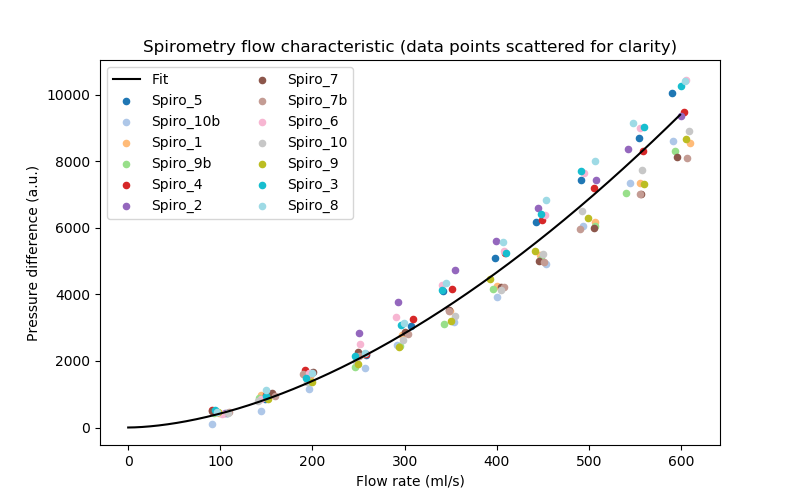

In [5]:
fig, ax = plt.subplots(1,1, figsize=FIGSIZE)
flow_range = np.arange(0, all_fp[:,0].max())
plt.plot(flow_range, a * (flow_range ** n), color='k', label='Fit')
cmap = CMAP(np.linspace(0,1,len(spiro_data)))[:,None,:]

for bidx,(bkey,bdf) in enumerate(spiro_data.items()): 
    for flow in np.unique(bdf.loc[:,'flow']):
        y = bdf.loc[bdf["flow"] == flow, 'pressure'].mean()
        jitter = 10 * (np.random.uniform(-1,1))
        if flow == 100:
            plt.scatter(x=flow + jitter, y=y, c=cmap[bidx], s=MARKSIZE, label=bkey)
        else: 
            plt.scatter(x=flow + jitter, y=y, c=cmap[bidx], s=MARKSIZE)
            
plt.legend(ncol=2)
plt.title("Spirometry flow characteristic (data points scattered for clarity)")
plt.xlabel("Flow rate (ml/s)")
plt.ylabel("Pressure difference (a.u.)")
plt.show()

The plot clearly shows that spiro variation is much more significant that anticipated. As a rough example: nominal settings are 400ml at 1:2 IE ratio, 20 RR, which corresponds to a flow rate of 400ml/s. The lowest/highest spiro readings at this flow are 3880 and 5650 respectively. Using the overall fit for all spiros, these extremes map to flows of 360ml/s and 450ml/s, which is a variation of almost ±50ml/s around the true value. Given this, it is logical to ask how the system manages to function relaibly at all. My guess is that the spiros behave differently in actual use compared to this experiment. The procedure used here (ramping up to fixed flow rates, holding them constant for a few secs) is completely different to the flow profile seen during inspiration. The rate at which flow changes during inspiration is also fast compared to the sampling resolution of the system (we previously had issues related to the sampling rate being too low). I think these two effects (quickly varying flow profile, relatively coarse sampling resolution) combine to give different system behaviour in actual use. 

The particularly concerning result here is the emergence of what may be a bi-modal distribution above 350ml/s (the spiros split into 2 groups). Note also that the repeat runs without buzzer (eg 7 vs 7b) actually show little difference: though the buzzer is a significant source of noise when examined with an oscilloscope, it is normally distributed and hence averages out over many samples. 

## 6.2.2 Spiro variation, single valve
The previous experiment was performed with unique pairs of spiro and Marshall valve. The procedure was repeated for 5 sprios, this time with same Marshall valve used for all (and the same OxVent). The aim was to investigate the Marshall valve as a source of variability. 

In [6]:
spiro_data_single_valve = loaders.load(op.join(ROOT, 'Spiro_variation'), 
                                        'spivar.*_PRDW', 5, ('time', 'pressure', 'flow'))

spiro_data_single_valve = zero_shift(spiro_data_single_valve)  

dict_keys(['spivar_s12', 'spivar_s10', 'spivar_s11', 'spivar_s5', 'spivar_s13'])


<IPython.core.display.Javascript object>


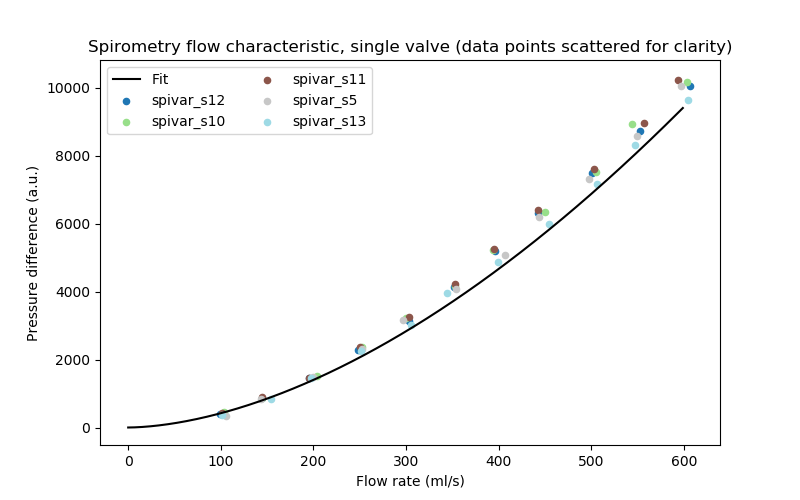

In [7]:
plt.figure(figsize=FIGSIZE)
cmap = CMAP(np.linspace(0,1,len(spiro_data_single_valve)))[:,None,:]
plt.plot(flow_range, a * (flow_range ** n), color='k', label='Fit')

for bidx,(bkey,bdf) in enumerate(spiro_data_single_valve.items()): 
    for flow in np.unique(bdf.loc[:,'flow']):
        y = bdf.loc[bdf["flow"] == flow, 'pressure'].mean()
        jitter = 15 * (np.random.uniform() - 0.5)
        if flow == 100:
            plt.scatter(x=flow + jitter, y=y, c=cmap[bidx], s=MARKSIZE, label=bkey)
        else: 
            plt.scatter(x=flow + jitter, y=y, c=cmap[bidx], s=MARKSIZE)
            
plt.legend(ncol=2)
plt.title("Spirometry flow characteristic, single valve (data points scattered for clarity)")
plt.xlabel("Flow rate (ml/s)")
plt.ylabel("Pressure difference (a.u.)")
plt.show()

The plot shows that the valve itself is indeed a source of variability, though not quite to the same extent as the spiro kit itself.

## 6.1 Flow measurement 
The same procedure as for the spiro test was used, but this time three spiros with neutral characteristics were selected from the previous plot (2, 4, 5) and 22 OxVents were tested (evenly split). The suffix SP refers to the spiro number as used in the above experiment.

In [8]:
flow_data = loaders.load(op.join(ROOT, 'flow_sensor'), 
                         'SN.*_PRDW.dat', 9, ('time', 'pressure', 'flow'))
flow_data = zero_shift(flow_data)
flow_data['SN0990_SP4'][::50]

dict_keys(['SN0990_SP4', 'SN0915_SP2', 'SN0993_SP5', 'SN0986_SP5', 'SN1001_SP5', 'SN0920_SP2', 'SN0945_SP5', 'SN0839_SP4', 'SN0944_SP4', 'SN0987_SP2', 'SN0942_SP2', 'SN0926_SP4', 'SN0988_SP2', 'SN0912_SP5', 'SN0918_SP4', 'SN0924_SP4', 'SN0998_SP5', 'SN0916_SP4', 'SN0913_SP2', 'SN0995_SP5', 'SN0923_SP4', 'SN1002_SP2'])


,time,pressure,flow
0,31834.0,550.032258,100.0
50,43036.0,1120.032258,150.0
100,62350.0,2198.032258,250.0
150,73617.0,2850.032258,300.0
200,92930.0,4495.032258,400.0
250,124191.0,6371.032258,500.0
300,141431.0,7532.032258,550.0


Fit a relationship of the form $\Delta P = a f ^ n$, where the $n$ is not constrained to be quadratic (previous testing showed a quadratic gave a poor fit)

In [9]:
# Stack all pressure-flow readings into a single array (NB equal weighting across datapoints)
all_fp = np.concatenate([ df.loc[:,["flow", "pressure"]] for df in flow_data.values() ], axis=0)

# Trim out rows with negative readings (caused by noise at low flow)
all_fp = all_fp[all_fp[:,1] > 0,:]
(n, loga) = np.polyfit(np.log(all_fp[:,0]), np.log(all_fp[:,1]), 1)

a = np.exp(loga)
print("a:", a, "n:", n)
rms_error = np.sqrt(((all_fp[:,1] - (a * all_fp[:,0] ** n))**2).mean())
print("RMS error (normalised to mean signal) {:2.2f}%".format(100 * rms_error / all_fp[:,1].mean()))

a: 0.39198220817680185 n: 1.5804067270360966
RMS error (normalised to mean signal) 9.34%


Plot fit against data

<IPython.core.display.Javascript object>


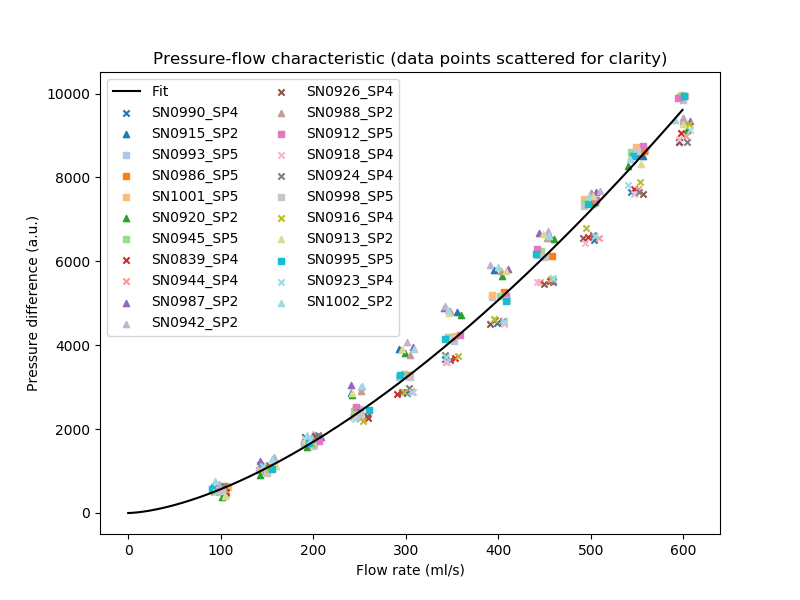

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
flow_range = np.arange(0, all_fp[:,0].max())
plt.plot(flow_range, a * (flow_range ** n), color='k', label='Fit')
cmap = CMAP(np.linspace(0,1,len(flow_data)))[:,None,:]

symbols = { 'SP2': '^', 'SP4': 'x', 'SP5': 's' }
for bidx,(bkey,bdf) in enumerate(flow_data.items()): 
    for flow in np.unique(bdf.loc[:,'flow']):
        y = bdf.loc[bdf["flow"] == flow, 'pressure'].mean()
        jitter = 10 * (np.random.uniform(-1,1))
        symbol = symbols[bkey[-3:]]
        if flow == 100:
            plt.scatter(x=flow + jitter, y=y, c=cmap[bidx], s=MARKSIZE, label=bkey, marker=symbol)
        else: 
            plt.scatter(x=flow + jitter, y=y, c=cmap[bidx], s=MARKSIZE, marker=symbol)
            
plt.legend(ncol=2)
plt.title("Pressure-flow characteristic (data points scattered for clarity)")
plt.xlabel("Flow rate (ml/s)")
plt.ylabel("Pressure difference (a.u.)")
plt.show()

The symbols used for each datapoint correspond to the spiro that was used to obtain the data (ie, all the triangles were obtained with the same spiro). The fit is somewhat tighter than that of the sprio variation test (6.2 above, RMS error of 14.4% vs 9.3%). This is presumably explained by the fact that three spiros with neutral characteristics were used for this experiment, therefore reducing their contribution to variability. The variation of the differential pressure sensor itself can be characterised by looking within clusters of the same symbol: within-spiro variation is clearly smaller than between-spiro variation, as evidenced by the formation of separate clusters for each spiro with little overlap (particularly >300ml/s). In comparison to the previous calibration coefficients (obtained during the initial development at S+N), this fit does give higher RMS error (9.3% vs 3.8%), but there are two important differences between this and the last calibration experiment: 
1. This fit was performed over a much larger dataset (22 OxVents and 3 spiros, whereas the last was performed with 4 OxVents, all of which used the same spiro) 
2. This fit was performed over a larger range of flow rates, whereas the last was over the range [0 400] ml


We previously used a weighting function to bias the fit in the range [200 300] ml; I have tried the same here but it makes a marginal difference at best.

## 6.3 Tidal volume drift
Test ongoing, bundled up with the bag durability?

## 6.4 Inspiration pressure 

The purpose of this test was to determine whether improvements can be made to the inspiratory pressure measurement algorithm, by measuring the pressure profile during operation. An OxVent was set at nominal settings: 400ml, 20 RR, IE 1:2, 37 Plimit, 10 PEEP and pressure readings (as measured by the internal sensor) were logged over USB. Simultaneously, a scope was used to log the voltage from the same sensor (the raw pressure signal); a successful test would be seeing little difference between the two traces (despite the lower sampling rate of the OxVent system). 

In [11]:
scope_pinsp = loaders.load(op.join(ROOT, 'pinsp'), '.*.csv', 6, 
                          ('time', 'voltage'), skip_header=3)['scope']
scope_pinsp = scope_pinsp.loc[:scope_pinsp.shape[0]//2,:]
scope_pinsp[::150]

dict_keys(['scope'])


,time,voltage
0,-7.84,1.2711
150,-6.34,1.3103
300,-4.84,1.2788
450,-3.34,1.2551
600,-1.84,1.2921
750,-0.34,1.2567
900,1.16,1.3009


Load the OxVent data. Note that the two traces have different units in both time voltage/pressure (due to different sampling rates, and the different variable being measured)

In [12]:
oxv_pinsp = loaders.load(op.join(ROOT, 'pinsp'), 'OxVent_2020-05-28-17-21-25_PRGR.dat',
                         29, ('time', 'pressure', 'na'))['OxVent']
oxv_pinsp[::50]

dict_keys(['OxVent'])


,time,pressure,na
0,64033.0,42270.0,0.0
50,65450.0,33623.0,0.0
100,66849.0,40997.0,0.0
150,68289.0,33940.0,0.0
200,69680.0,39443.0,0.0
250,71126.0,33869.0,0.0
300,72511.0,36905.0,0.0
350,73964.0,34095.0,0.0


In order to get the two traces to match up, we need to shift the data in time and scale the data to map voltage to pressure. A zero-point calibration was used: if we assume that the minimum voltage corresponds to the minimum pressure, we can use that to work out a scaling factor that can then be applied to all other values. Previous work has confirmed that the static pressure sensor in the OxVent does have a linear characteristic, so we should see the maximum values correspond to each other after scaling. 

<IPython.core.display.Javascript object>


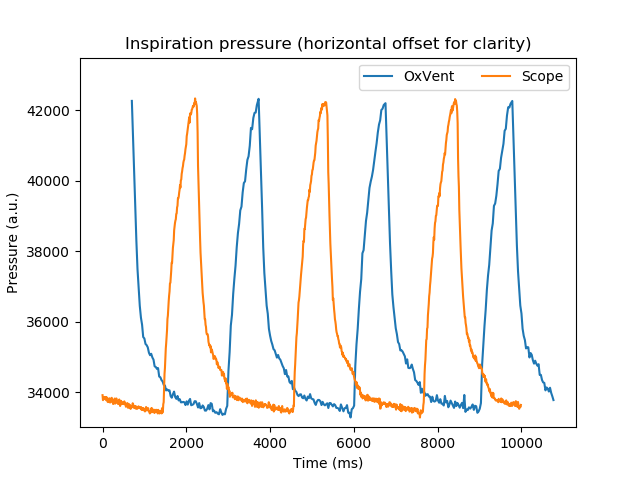

In [13]:
min_adc = oxv_pinsp.min(0)
min_scope = scope_pinsp.min(0)
scope_pinsp.loc[0,"time"]

fig = plt.figure()
plt.plot(oxv_pinsp.loc[:,"time"] - oxv_pinsp.loc[0,"time"] + 700, 
         oxv_pinsp.loc[:,"pressure"], label='OxVent')
plt.plot((scope_pinsp["time"] - scope_pinsp.loc[0,"time"]) * 1000, 
          scope_pinsp["voltage"] * min_adc[1] / min_scope['voltage'], label='Scope')
plt.legend(ncol=2)
plt.ylabel("Pressure (a.u.)")
plt.xlabel("Time (ms)")
plt.title("Inspiration pressure (horizontal offset for clarity)")
plt.ylim(33000, 43500)
plt.show()

As can be seen from the plot, there is excellent agreement between the two traces and it can be concluded that the OxVent is measuring pressure with sufficient frequency to accurately capture the dynamics of respiration. 

## 6.5 Achievable therapy configuration 
What settings can the system actually provide? 3 devices were tested at different VT, RR and IE ratio, which can be reduced down to two independent variables: inspiratory flow rate and expiration time. Plimit was set at 45 to ensure no devices were pressure-limited. 

In [14]:
therapy_data = pd.read_excel(op.join(ROOT, 'therapy', 'oxvent_air_rates.xlsx'), skiprows=1, usecols='A:N')
therapy_data = therapy_data.loc[(~therapy_data.isna()).all(1),:]
therapy_data

,Tidal Volume,Resp Rate,I:E Ratio (1:X),Cycle Time (s),Insp. Time (s),Exp. Time (s),Insp. Rate (ml/s),Exp. Rate (ml/s),06 Achieved,06 Ppeak,03 Achieved,03 Ppeak,05 Achieved,05 Ppeak
17,600,30,2,2.00,0.67,1.33,900.00,450.00,535.0,35.0,575.0,39.0,600.0,43.0
21,600,22,3,2.73,0.68,2.05,880.00,293.33,545.0,35.0,600.0,36.0,600.0,42.0
26,600,28,2,2.14,0.71,1.43,840.00,420.00,560.0,36.0,600.0,43.0,600.0,41.0
27,450,28,3,2.14,0.54,1.61,840.00,280.00,410.0,34.0,435.0,39.0,450.0,40.0
29,500,25,3,2.40,0.60,1.80,833.33,277.78,455.0,35.0,485.0,38.0,500.0,41.0
30,550,30,2,2.00,0.67,1.33,825.00,412.50,540.0,34.0,550.0,38.0,550.0,39.0
31,600,27,2,2.22,0.74,1.48,810.00,405.00,600.0,37.0,600.0,38.0,600.0,39.0
32,450,27,3,2.22,0.56,1.67,810.00,270.00,440.0,33.0,450.0,36.0,450.0,37.0
34,400,30,3,2.00,0.50,1.50,800.00,266.67,390.0,32.0,395.0,35.0,400.0,36.0
35,500,24,3,2.50,0.63,1.88,800.00,266.67,480.0,35.0,500.0,37.0,500.0,38.0


Each row in the table gives a unique pair of (inspiratory flow rate, expiratory time) [the latter is bag re-inflation time]. For the three devices tested, pick the one that achieved the lowest tidal volume and calculate the error as % of target to give a worse-case scenario. 

In [15]:
min_volume = therapy_data.filter(regex='Achieved').min(1)
vol_error = 100 * (min_volume - therapy_data["Tidal Volume"]) / therapy_data["Tidal Volume"]

Plot a contour map of tidal volume error across the configuration space. As we did not sweep the space uniformly (nor did we sweep the whole space), triangulation is used to fill in the missing values (which may not be totally accurate as a result). The acquired datapoints are plotted in black for clarity (these are not interpolated). 

<IPython.core.display.Javascript object>


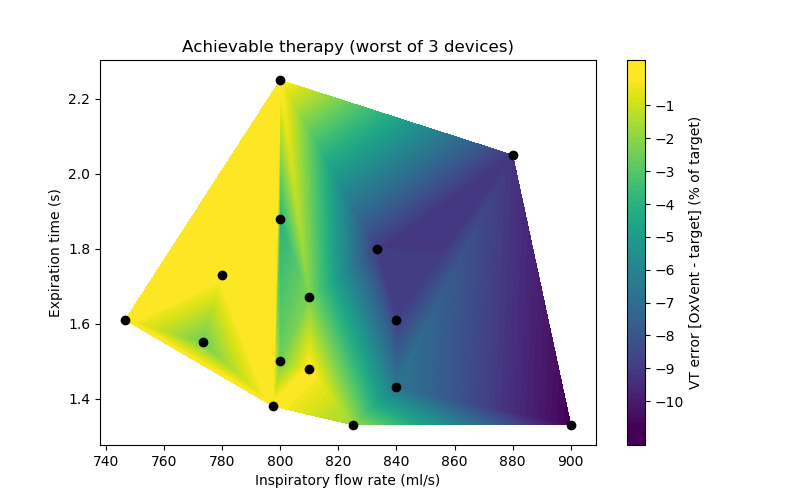

In [16]:
fig = plt.figure(figsize=FIGSIZE)
x = therapy_data["Insp. Rate (ml/s)"].values
y = therapy_data["Exp. Time (s)"].values
plt.tricontourf(x, y, vol_error.values, 100, extend='both')
plt.colorbar(extendrect=True, ticks=range(0,-11,-1), label='VT error [OxVent - target] (% of target)', )
plt.scatter(x,y,c='k')
plt.xlabel("Inspiratory flow rate (ml/s)")
plt.ylabel("Expiration time (s)")
plt.title("Achievable therapy (worst of 3 devices)")
plt.show()

Unsurprisingly, increasing poor operation was seen as flow rates increased and expiration time decreased (towards the bottom RHS of the plot). There is a notable ridge at 800ml/s that separates the region of accetable operation (flows <= 800) from the region of steadily deteriorating operation (flows > 800). 

## 6.6 Low flow control stability 

## 6.7 Burkert valve characterisation 
What is the current-flow characteristic of the different solenoid valves? Testing showed that the SMC is able to provide higher flow rates, thus permitting better operation at high-stress configurations. Note that the other datasets in this folder (without suffix \_dual) were acquired with a single inline flow meter, which was found to restrict max flow for both valves at high current. The \dual runs were repeated with parallel paths to correct for this and are presented below.   

In [17]:
valve_data = loaders.load(op.join(ROOT, 'valve'), 'VALVE_[a-z].*', 13, ('current', 'flow'))
valve_data['VALVE_smc'][::5]

dict_keys(['VALVE_smc', 'VALVE_burkert'])


,current,flow
0,110.0,0.00337
5,120.0,0.01267
10,130.0,2.71813
15,140.0,9.14812
20,150.0,15.88459
25,160.0,25.32356
30,170.0,29.44803


<IPython.core.display.Javascript object>


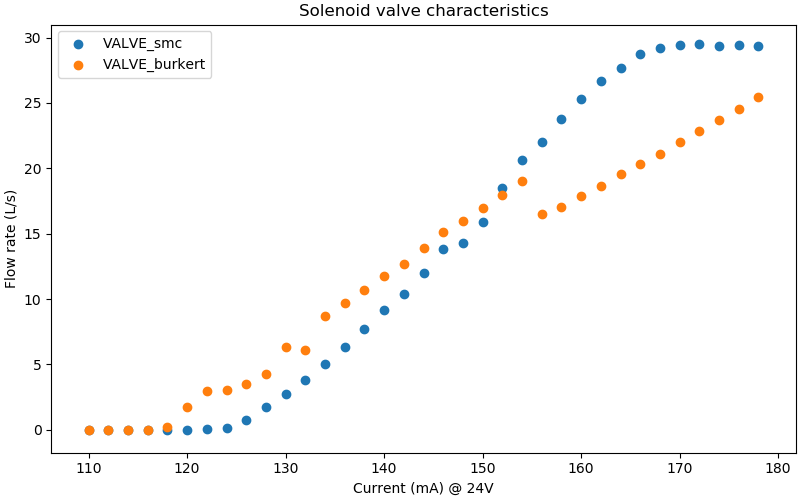

In [18]:
fig = plt.figure(figsize=FIGSIZE, constrained_layout=True)
for idx,(vid,vdf) in enumerate(valve_data.items()): 
    plt.scatter(vdf["current"].values, vdf["flow"].values, label=vid)
plt.legend()
plt.title("Solenoid valve characteristics")
plt.xlabel("Current (mA) @ 24V")
plt.ylabel("Flow rate (L/s)")
plt.show()

The SMC trace is markedly smoother across the current range than the SMC valve. Although the 'switch-on' point of the Burkert comes before that of the SMC (~115 mA vs 125mA, though there is variation between valves of the same type), the SMC has a stronger response (greater increase in flow for increase in current) and allows higher max flow rates when saturated. The Burkert seems to have a physically smaller aperture internally, which means the maxiumum flow rate it can deliver in the configuration tested here is smaller, which ultimately means OxVents with this valve **cannot deliver high-stress ventilation (eg 600ml @ 25 RR)**. It is for this reason that we strongly recommend using only SMC valves in the future. 

## 6.8 PID startup stability  
For a given tidal volume and lung compliance, how quickly does the system achieve target operation? Nominal settings were used (20 RR, 1:2 IE ratio, 10 PEEP)

In [19]:
lowflow_data = loaders.load(op.join(ROOT, 'startup'), '.*.csv', 4, 
                          ('cycles', 'target', 'compliance', 'reference', 'oxvent'), skip_header=1)['68_PID']
lowflow_data[::25]

dict_keys(['68_PID'])


,cycles,target,compliance,reference,oxvent
0,1.0,250.0,10.0,68.0,54.0
25,26.0,250.0,10.0,250.0,268.0
50,21.0,450.0,10.0,473.0,451.0
75,16.0,600.0,10.0,522.0,508.0
100,11.0,250.0,30.0,209.0,192.0
125,6.0,450.0,30.0,398.0,385.0
150,1.0,600.0,30.0,582.0,675.0


Plot tidal volume for each cycle after startup, with separate traces for each (target, compliance) pair

<IPython.core.display.Javascript object>


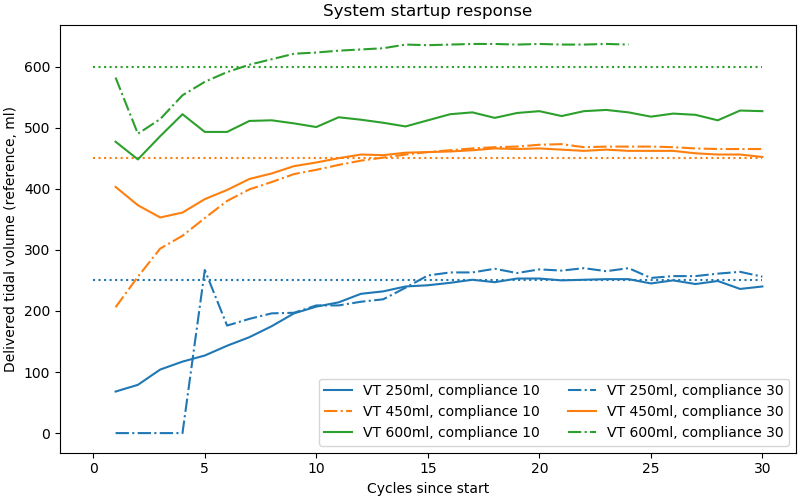

In [20]:
compliances = np.unique(lowflow_data["compliance"])
targets = np.unique(lowflow_data["target"])
lines = ['-', '-.']
cmap = CMAP(np.linspace(0,1,10))[:,None,:]
plt.figure(figsize=FIGSIZE, constrained_layout=True)

for idx,vt in enumerate(targets):
    plt.plot([0,30], [vt,vt], color=np.squeeze(cmap[idx]), linestyle=':')
    
for idx,(comp,vt) in enumerate(itertools.product(compliances, targets)):
    data = lowflow_data.where((lowflow_data["compliance"] == comp) & (lowflow_data["target"] == vt))
    plt.plot(data["cycles"], data["reference"], color=np.squeeze(cmap[idx % 3]), 
             linestyle=lines[idx % 2], label='VT {:.0f}ml, compliance {:.0f}'.format(vt, comp))

plt.ylabel("Delivered tidal volume (reference, ml)")
plt.xlabel("Cycles since start")
plt.title("System startup response")
plt.legend(ncol=2)
plt.show()

Note that the reference tidal volume, not the OxVent measured value, is plotted. The results of this test are mixed. At typical settings, (400ml) the system performs well, reaching target in about 10 cycles (30s). Other targets only a few extra cycles to reach stability (if not target). Poor performance was observed on: 
1. 600ml, 10 compliance: low tidal volume due to pressure-limiting behaviour, so is reflective of correctly functioning safety features
2. 600ml, 30 compliance: high tidal volume due to poor calibration of internal flow measurement. This fits a general trend that was observed across devices with under-estimation of flow at high flow rates (leading to excessive tidal volumes) 
3. 250ml, 30 compliance: numerous empty cycles before ventilation started. This is because this configuration called for extremely low pressures in the vent box (small volume, flexible lung), and at these low pressures the Marshall valve that supplies the vent box does not perform as required (Harrison has since confirmed that the other model of Marshall valve does not behave in this way) 

## 6.9 Tidal volume  
General test of consistency and accuracy at typical settings: 
1. 250ml, 20RR, 1:2 IE ratio, 10 PEEP
2. 400ml, 20RR, 1:2 IE ratio, 10 PEEP 
3. 600ml, 20RR, 1:2 IE ratio, 10 PEEP

In [21]:
tidal_data = loaders.load(op.join(ROOT, 'tidal'), '.*.csv', 4, 
                          ('target', 'reference', 'oxvent'))
tidal_data['X2044_R30_018202'][::5]

dict_keys(['X2044_R30_018202', 'X2044_R30_622603', 'X2044_R30_622602', 'X2044_R30_622601', 'X2044_R35_018301', 'X2044_R30_622604', 'X2044_R35_018302', 'X2044_R30_017603'])


,target,reference,oxvent
0,400.0,461.0,397.0
5,400.0,462.0,405.0
10,600.0,671.0,596.0
15,600.0,673.0,601.0
20,250.0,286.0,253.0
25,250.0,286.0,248.0
30,250.0,286.0,249.0
35,250.0,297.0,263.0


<IPython.core.display.Javascript object>


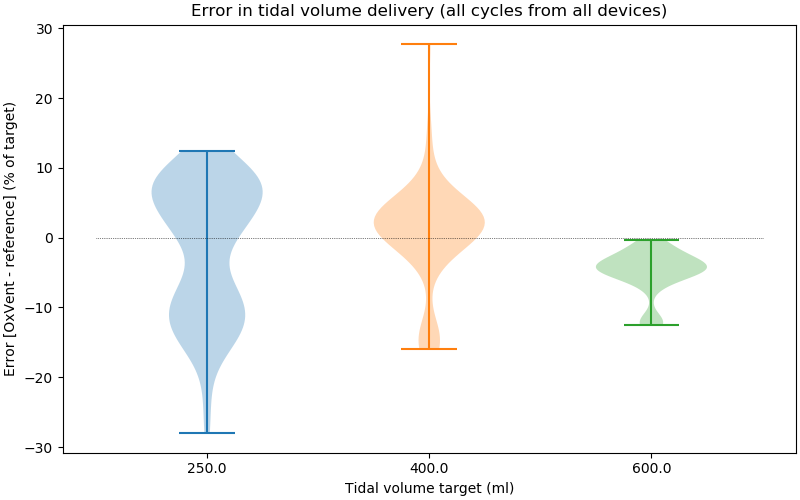

In [22]:
all_tidal = pd.concat(list(tidal_data.values()))

targets = np.unique(tidal_data[(next(iter(tidal_data)))]['target'])
cmap = CMAP(np.linspace(0,1,len(tidal_data)))[:,None,:]
fig = plt.figure(figsize=FIGSIZE, constrained_layout=True)

for vtidx, vt in enumerate(targets): 
    data = all_tidal.loc[all_tidal["target"] == vt,:]
    err = 100 * (data["oxvent"] - data["reference"]) / vt
    plt.violinplot([err], [vtidx], vert=True)
        
plt.plot([-0.5, targets.size-0.5], [0,0], 'k:', linewidth=0.5)
plt.xticks(range(targets.size), targets)
plt.xlabel("Tidal volume target (ml)")
plt.ylabel("Error [OxVent - reference] (% of target)")
plt.title("Error in tidal volume delivery (all cycles from all devices)")
plt.show()

## 6.10 Ambu bag durability
Does the performance of the bag degrade with long term use? Originally this was planned to run with a multi-use (as opposed to single-use) bag from Marshall, however none were available in Hull so we set off a device with a single use bag (ie, the same spec as all the OxVents that have been built to date). 

Set off a device (/018202) at 600 VT, 27 RR, 1:2, 45 Plimit, 10 PEEP. Checked calibration against IMT, was within 15ml of reference. Left running at these settings, start time 1522 on 27/5. We will observe if it falls away from target over time, or if the Pinsp required to drive changes (started @ 43). 

## 6.11 Temperature and humidity 
Does the bag degrade over time in hot/humid environment etc? We were not able to test this. 

## 6.12 Minimum supply voltage 
Run at high-stress configuration, and check targets can be achieved whilst supply voltage is progressively reduced. 

600ml, RR 25, PEEP 5, IE 1:2, Plimit 45. 

In [23]:
volt_data = loaders.load(op.join(ROOT, 'voltage'), 'SMC.csv', 4, ('volts', 'target', 'actual'))['SMC']
volt_data[::10]

dict_keys(['SMC'])


,volts,target,actual
0,24.0,600.0,602.0
10,24.0,600.0,605.0
20,23.0,600.0,602.0
30,22.0,600.0,576.0
40,22.0,600.0,588.0
50,21.0,600.0,531.0


Plot error in tidal volume wrt. target at each supply voltage. These are violin plots over the individual respiration cycles recorded at each voltage. 

<IPython.core.display.Javascript object>


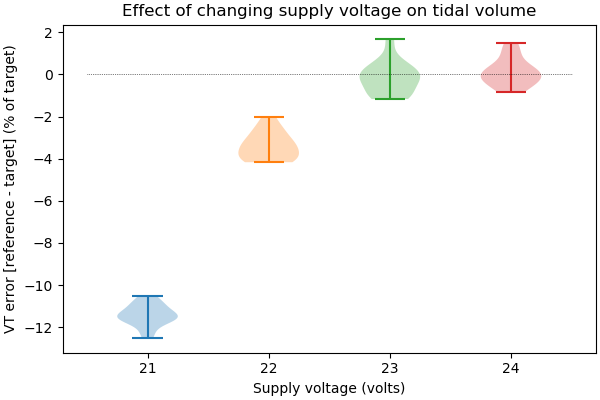

In [24]:
volts = np.unique(volt_data["volts"])
cmap = CMAP(np.linspace(0,1,10))[:,None,:]
fig = plt.figure(figsize=(6,4), constrained_layout=True)

plt.plot([volts.min()-0.5, volts.max()+0.5], [0,0], 'k:', linewidth=0.5)
for idx,volt in enumerate(volts):
    data = volt_data.loc[volt_data["volts"] == volt,:]
    err = 100 * (data["actual"] - data["target"]) / data["target"]
    plt.violinplot([err], [volt], vert=True)

plt.title('Effect of changing supply voltage on tidal volume')
plt.ylabel('VT error [reference - target] (% of target)')
plt.xlabel('Supply voltage (volts)')
plt.xticks(volts)
plt.show()

The results of this test are positive: correct operation was observed at 24/23V, a small decrease in tidal volume delivery was observed at 22V (around 3% error), and at 21V the system was operating just below the boundary of acceptable behaviour (11% error). Note that in order to perform this test we had to disconnect the UPS from the board and wire in a bench supply; for a similar situation to occur in clinical use would imply a serious issue with the UPS itself as it is designed to maintain a constant voltage. 

## 6.13 Air supply pressure 
Run at high-stress configuration, check correct operation with falling air pressure
Run at low-stress configuration, check correct operation with increasing air pressue

Low pressure test: 600ml, RR 25, PEEP 5, IE 1:2, Plimit 45
High pressure test: 250ml, RR15, PEEP 10, I:E? Plimit?

In [25]:
air_data = loaders.load(op.join(ROOT, 'pressure_drop'), '.*SMC.csv', 4, ('pressure', 'target', 'actual'))
air_data = pd.concat(list(air_data.values()))
air_data[::15]

dict_keys(['DV613_MAX_SMC', 'DV613_MIN_SMC'])


,pressure,target,actual
0,4.0,450.0,440.0
15,4.5,450.0,458.0
30,5.0,450.0,460.0
45,5.5,450.0,454.0
60,6.0,450.0,440.0
0,4.0,600.0,592.0
15,3.5,600.0,536.0
30,3.0,600.0,451.0


Plot error in tidal volume wrt. target at each supply pressure. These are violin plots over the individual respiration cycles recorded at each pressure. 

<IPython.core.display.Javascript object>


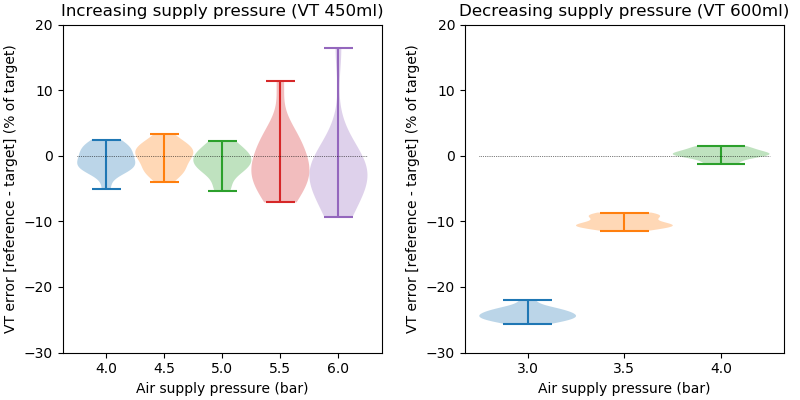

In [26]:
vts = np.unique(air_data["target"])
cmap = CMAP(np.linspace(0,1,10))[:,None,:]
fig, axes = plt.subplots(1, vts.size, figsize=(8,4), constrained_layout=True)

for vtidx,(vt,ax) in enumerate(zip(vts, axes)):
    psupp = np.unique(air_data["pressure"][air_data["target"] == vt])
    ax.plot([psupp.min()-0.25, psupp.max()+0.25], [0,0], 'k:', linewidth=0.5)
    for idx,ps in enumerate(psupp):
        data = air_data[(air_data["pressure"] == ps) & (air_data["target"] == vt)]
        if not data.empty:
            err = 100 * (data["actual"] - vt) / vt
            ax.violinplot([err], [ps], vert=True)

    ax.set_xlabel('Air supply pressure (bar)')
    ax.set_ylabel('VT error [reference - target] (% of target)')
    ax.set_xticks(psupp)
    ax.set_ylim(-30, 20)
    
axes[0].set_title('Increasing supply pressure (VT 450ml)')
axes[1].set_title('Decreasing supply pressure (VT 600ml)')
plt.show()

Unsurprisingly, the system struggles to deliver high-stress ventilation with falling supply pressure, though at 3.5bar the error wrt. target is around 10%, just on the bounds of acceptable behaviour. The system generally functioned well with increasing supply pressure, though there were individual high-volume deliveries at 5.5 and 6bar respectively (max 15% above target, at 6bar). 

## Other observations

1. Vertical/horizontal position of the unit. If the unit is switched on and goes through calibration in either a horizontal or vertical position, and is subsequently moved to the other position during operation, a large error in tidal volume *measurement* can be seen (easily > 10% of reference). 

2. Alarm. The alarm adds significant noise into the signal from the differential pressure sensor, but testing has shown that this is white noise with a random distribution and can therefore be mitigated into two ways: a) averaging over many samples (as is currently the case) and b) disabling alarm noises during inspiration, when accurate flow measurements are of paramount importance. Although (a) is a good start, we would definitely recommend implementing (b) as there is still an measurable error in measurement with (a) in isolation. The importance of this increases at low-flow operation as the SNR is poorer, hence the potential for error is greater. 

3. Dependence of flow measurement on PEEP. We observed a dependence of tidal volume measurement on PEEP for fixed operating parameters. In particular, at low PEEP (< 5 cmH2O), differences in excess of 10% of target were observed, whereas for PEEP settings of ~10 the differences were much reduced, *for the same RR and VT target*. This could be another alarm-related noise issue: for lower PEEPs, the voltage signals produced by the pressure sensors will be weaker, hence the SNR will decrease (assuming the alarm adds in noise of relatively fixed magnitude). Nevertheless, averaging over many samples should correct for this, so the true cause remains an open question. 

4. PEEP valves are highly ambiguous components. The numbers on the devices have a poor relation to the pressures they produce in the airway, and for long expiration times / small tidal volumes it is essentially impossible to maintain any significant PEEP (due to the leakiness of many components in the airway system). No doubt this will not be news to any clinicans, nor will they not think this of great significance, but as we have seen in the past, we cannot assume the same frontline/hands-on attitude from regulators so this is worth bearing in mind. 

5. Marshall valve does itself have a measurable effect on accuracy of tidal volume delivery, as does the angular position of the interface between the valve and the spiro kit (both are tubular, so there are 360deg of alignment between the two). Although one could dig into the details and identify which of the two components is the source of greater variability, I think from a system point of view we may be better regarding them as one fixed assembly and testing both together. This is more relevant for clinical use: after all, every system comes with one spiro connected into one valve, they are not meant to be separated during the liftime of the system, so it is their joint properties that will determine the accuracy of the overall system. We also observed the valve that supplies the vent box itself (not the spiro) not behaving as required at low pressures, leading to a total loss of ventilation around ~250ml <14 RR. **Harrison has since tested an alternative design of Marshall valve and found better behaviour, so going forwards these should be used.**

6. Hysterisis. As mentioned in the above point, low-flow ventilation can be extremely unreliable in the current setup. We also noted a significant hysterisis effect that we have not been able to explain. For a target of 250 ml, 10RR, 1:2 IE ratio, the system is much more likely to achieve stability if it is started at default settings (400ml 20RR) and then adjusted *down* to the new target. By contrast, if the system is switched on and the target is entered before starting ventilation, the system has very little chance of reaching stability from a standing start. This could be hysterisis in software or hardware. 
